# Atividade 3

## Trabalhando o novo dataset conforme o conteúdo da aula

In [55]:
from sklearn.datasets import load_wine

dataset = load_wine()
X, y = dataset.data, dataset.target

In [56]:
dataset.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [57]:
dataset.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

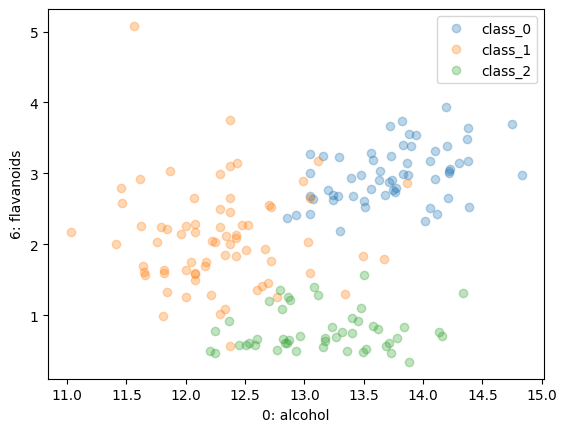

In [58]:
import matplotlib.pyplot as plt

i, j = 0, 6
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")

for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], 'o', alpha=0.3, label=f"{dataset.target_names[k]}")

plt.legend()
plt.show()

In [59]:
from collections import Counter
import numpy as np

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

In [60]:
def impureza(y): # implementando metrica Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i, k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  resultado = 1 - sum(probabilidades ** 2)
  return resultado

impureza(y[:])

0.6583133442747129

In [61]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impureza_maiores = impureza(y[maiores])
  proporcao_maiores = sum(maiores)/len(y)
  impureza_menores = impureza(y[~maiores])
  proporcao_menores = sum(~maiores)/len(y)
  impureza_total = proporcao_maiores*impureza_maiores + proporcao_menores*impureza_menores
  return impureza_total, impureza_menores, impureza_maiores

impurezaValor(X[:,2], y, 2.5)

(0.6434985114760395, 0.6419753086419754, 0.647189349112426)

In [62]:
def melhorValor(x, y): # heuristica vista na aula
  resultado = None
  menor_impureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmin+xmax)/2
    impureza_total, impureza_menores, impureza_maiores = impurezaValor(x, y, valor)
    if impureza_total < menor_impureza:
      menor_impureza = impureza_total
      resultado = valor
      if impureza_maiores == 0 or impureza_menores == 0:
        break
      if impureza_maiores < impureza_menores:
        xmin = valor
      else:
        xmax = valor
      pass
    else:
      break
  return resultado, menor_impureza

melhorValor(X[:,2], y)


(2.295, 0.6139307817100282)

In [63]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

melhorCaracteristica(X, y)

(0.43761750381193476, 12, 979.0)

In [64]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    maiores = X[:, self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores, :], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores, :], y[~maiores])
      pass
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:, self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
modelo.predict(X)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

1.0

In [65]:
from sklearn.model_selection import cross_validate
import time

start_time = time.time()
scores = cross_validate(modelo, X, y)
end_time = time.time()

execution_time = end_time - start_time

scores['test_score'], np.mean(scores['test_score']), execution_time

(array([0.77777778, 0.88888889, 0.83333333, 1.        , 0.97142857]),
 0.8942857142857144,
 0.6067993640899658)

In [66]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
  modelo.fit(X, y)
  x0s = np.linspace(np.min(X[:,0]-0.2), np.max(X[:,0]+0.2), 100)
  x1s = np.linspace(np.min(X[:,1]-0.2), np.max(X[:,1]+0.2), 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  Xdec = np.c_[x0.ravel(), x1.ravel()]
  ypred = modelo.predict(Xdec)
  plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha = 0.25)
  for k in set(y):
   plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', alpha= 0.7, label=f"{dataset.target_names[k]}")

  plt.legend()
  plt.show()

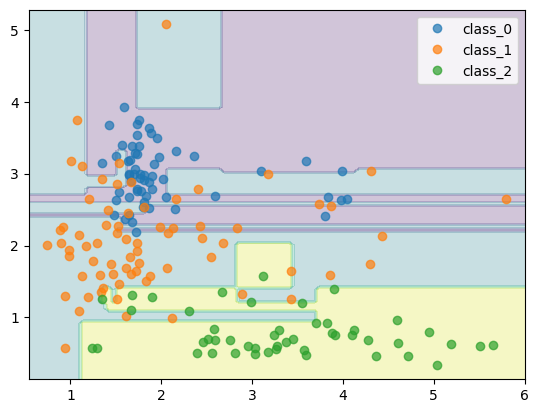

In [67]:
plotDecisao(modelo, X[:,[1,6]], y)

## Implementando a Nova Heuristica

In [68]:
def melhorValor(x, y): #nova heuristica
    resultado = None
    menor_impureza = float('inf')
    sorted_indices = np.argsort(x)

    for i in range(len(x) - 1):
        valor = (x[sorted_indices[i]] + x[sorted_indices[i + 1]]) / 2
        impureza_total, impureza_menores, impureza_maiores = impurezaValor(x, y, valor)
        if impureza_total < menor_impureza:
            menor_impureza = impureza_total
            resultado = valor
            if impureza_maiores == 0 or impureza_menores == 0:
                break
            if impureza_maiores < impureza_menores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return resultado, menor_impureza

In [69]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    if self.valor is not None:
        maiores = X[:, self.caracteristica] > self.valor
        if sum(maiores) > 0 and sum(~maiores) > 0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores, :], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores, :], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    else:
        self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:, self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
modelo.predict(X)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

1.0

In [72]:
start_time = time.time()
scores = cross_validate(modelo, X, y)
end_time = time.time()

execution_time = end_time - start_time

scores['test_score'], np.mean(scores['test_score']), execution_time

(array([0.83333333, 0.91666667, 0.97222222, 0.97142857, 0.91428571]),
 0.9215873015873017,
 0.6648480892181396)

### Qual heurística apresenta melhor desempenho de classificação no novo dataset?
- A nova implementação apresentou um melhor desempenho:
  - Média Pontuação Implementação da Aula: **0.8942857142857144**
  - Média Pontuação Nova Implementação: **0.9215873015873017**


### Qual heurística treina seus modelos mais rapidamente?
- Na nova implementação, apesar de obter um melhor desempenho, houve um leve aumento no tempo de execução:
  - Tempo de Execução Implementação da Aula: **0.6067993640899658s**
  - Tempo de Execução Nova Implementação: **0.6648480892181396s**